In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utilsforecast.plotting import plot_series as plot_series_utils
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import os 
from plotnine import *

plt.style.use("ggplot")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
from fpppy.utils import plot_series

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

# Setup
Code below reads in historical gas prices and weekly CPI data. Data are then filered for unleaded gasoline prices in Toronto and prices are rebased to 2025 dollars using the following equation: 

$$
\text{Price}_{{2025 dollars}_t} = \frac{\text{CPI}_{2025}}{CPI_t} * \text{price}_t
$$

Note this correction needs to be improved because the CPI for gasoline reflects the volatility of gasoline prices and so yields unreasonable values when CPI values are high. As an example, in 2022, gas prices rose a bit above $2.00 but,when corrected for inflation using hte gasoline-specific CPI, the price in terms of 2025 dollars was $1.42 (which is just patently false). Therefore, a more stable CPI is needed that better reflects affordability of living conditions. The following options might be useful: 

1. All-items CPI
2. Core CPI (excluding food and energy)
3. Real wage/income comparisons 

In [3]:
df_gas = pd.read_csv('data/raw/fueltypesall.csv')

# convert date to datetime object 
df_gas['Date'] = pd.to_datetime(df_gas['Date'])
df_gas.drop('Type de carburant', axis=1, inplace=True)

# convert to long format 
df_gas = pd.melt(frame=df_gas, id_vars=['Date', 'Fuel Type'], 
        var_name='city',value_name='price')
df_gas = df_gas.query(
    "city == 'Toronto East/Est' &  `Fuel Type` == 'Regular Unleaded Gasoline'")

# read in inflation data
df_inflation = pd.read_csv('data/raw/1810000401_databaseLoadingData.csv')
df_inflation.columns = df_inflation.columns.str.lower()
df_gas_inf = df_inflation.query("`products and product groups` == 'Gasoline'").copy()
                                   
# compute dollars in terms of 2025 dollars
# 1) Compute CPIs centered on 2025
value_25 = df_gas_inf.query('ref_date == "2025-06"')['value']
df_gas_inf['cpi_2025'] = value_25.values/df_gas_inf['value']

# merge in CPI value based on year-month and compute 
df_gas['year_month'] = df_gas["Date"].dt.strftime("%Y-%m")
df_gas_inf["ref_date"] = pd.to_datetime(df_gas_inf["ref_date"])
df_gas_inf['date_ymw'] = df_gas_inf["ref_date"].dt.strftime("%Y-%m")

cols = ['date_ymw', 'value', 'cpi_2025']
df_gas = pd.merge(left=df_gas, right=df_gas_inf[cols],
                  left_on='year_month', right_on='date_ymw', how='left')


# NOTE: replace 1990-01 with 1990-02 and 2025-07 with 2025-06
df_gas.loc[df_gas['year_month'].eq("1990-01"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("1990-02"), 'cpi_2025'].iloc[0]
df_gas.loc[df_gas['year_month'].eq("2025-07"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("2025-06"), 'cpi_2025'].iloc[0]

assert (df_gas['cpi_2025'].isna().sum() == 0), '''Check missing cpi_2025 values'''

# compute price adjusted metrics 
df_gas['price_2025'] = df_gas['price'] * df_gas['cpi_2025']

assert (df_gas['price_2025'].isna().sum() == 0), '''Check missing price_2025 values'''

# create toronto data
df_toronto = df_gas.query("city == 'Toronto East/Est'" )
df_toronto.to_csv('data/processed/data_toronto_proc.csv', index=False)

Code below downloads all data sets from Forecasting: Principles and Practice, the Pythonic Way.

In [97]:
import os
import re
import requests

DOWNLOAD_DIR = os.path.join("data", "raw")

if not os.listdir(DOWNLOAD_DIR):
    print("Directory is empty → downloading datasets...")

    BASE_URL = "https://otexts.com/fpppy/data/"
    DOWNLOAD_DIR = os.path.join("data", "raw")
    os.makedirs(DOWNLOAD_DIR, exist_ok=True)

    # Craft headers to mimic a browser
    HEADERS = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/115.0.5790.110 Safari/537.36'
        )
    }

    # 1. Fetch the data listing page with browser-like headers
    resp = requests.get(BASE_URL, headers=HEADERS)
    resp.raise_for_status()
    html = resp.text

    # 2. Extract CSV (and ZIP) filenames
    filenames = sorted(set(re.findall(r'([A-Za-z0-9_\-]+\.csv)', html)))
    filenames.insert(0, "data.zip")  # include the ZIP archive if present

    # 3. Download each file
    for fname in filenames:
        url = BASE_URL + fname
        dest = os.path.join(DOWNLOAD_DIR, fname)
        if os.path.exists(dest):
            print(f"Skipping (already exists): {fname}")
            continue
        print(f"Downloading {fname} ...")
        r = requests.get(url, headers=HEADERS, stream=True)
        try:
            r.raise_for_status()
            with open(dest, "wb") as f:
                for chunk in r.iter_content(8192):
                    f.write(chunk)
            print(f" → Downloaded: {fname}")
        except requests.HTTPError as e:
            print(f"  ! Download failed ({e})")


# 2. Time series graphics


## 2.2. Time plots

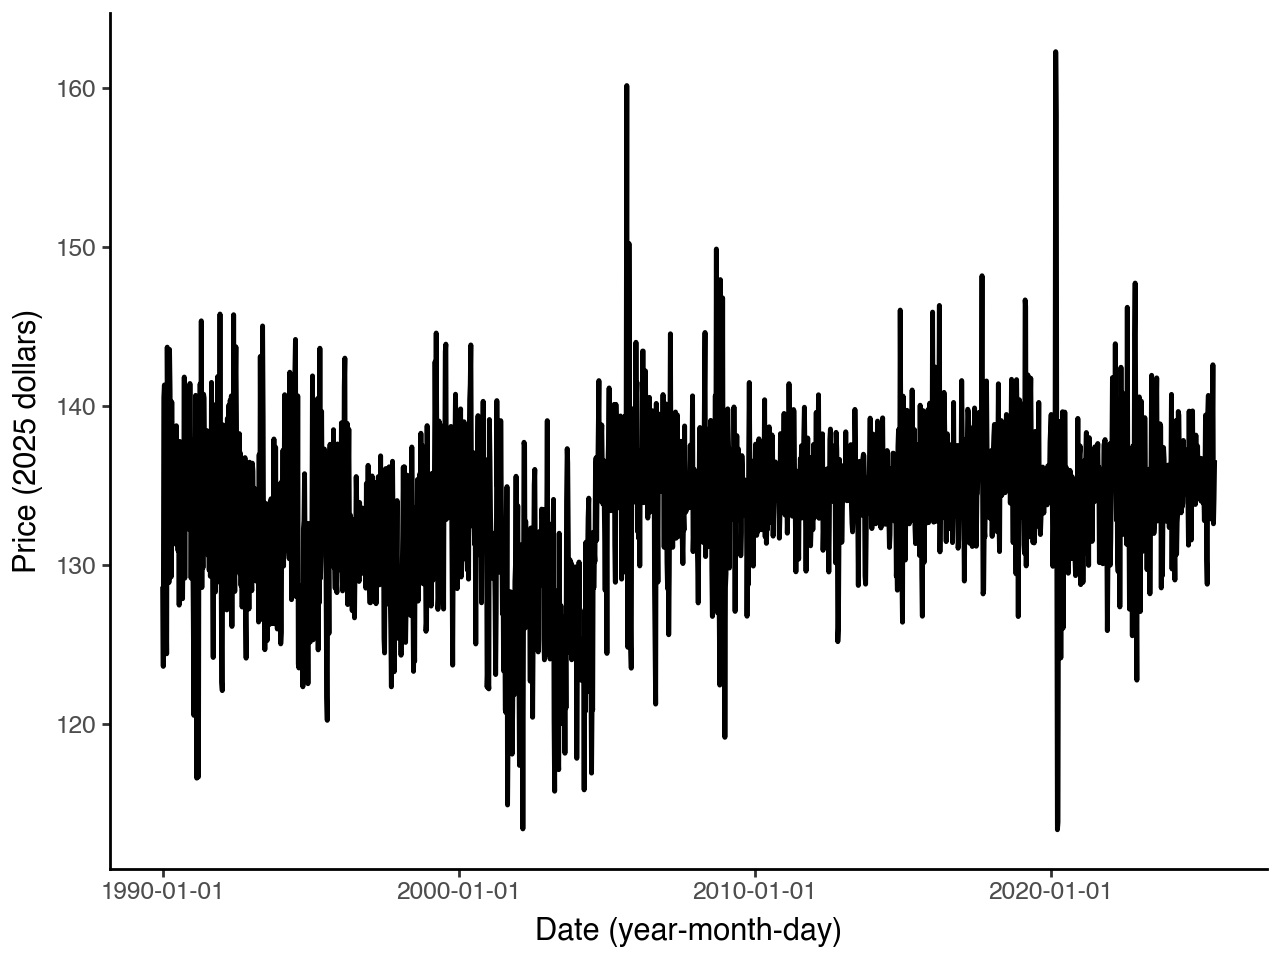

In [4]:
df_toronto = pd.read_csv("data/processed/data_toronto_proc.csv")
df_toronto["year_month"] = pd.to_datetime(df_toronto["year_month"])
df_toronto["Date"] = pd.to_datetime(df_toronto["Date"])

(ggplot(data=df_toronto, mapping=aes(x='Date', y='price_2025')) + 
  geom_line(size=1) + 
  labs(x='Date (year-month-day)', y='Price (2025 dollars)') + 
  theme_classic())


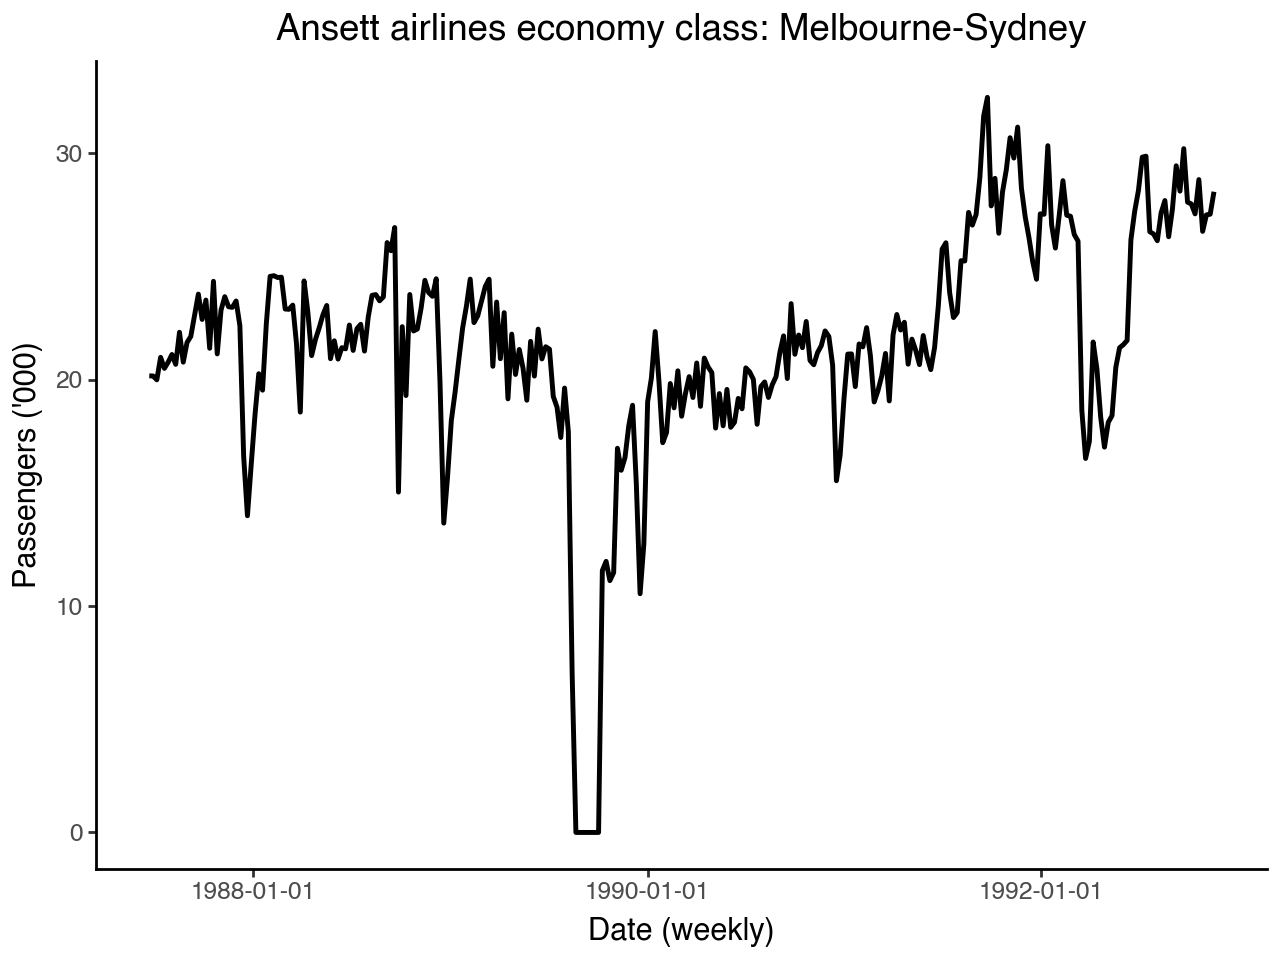

In [24]:
# some other time plots from book 
df_ansett = pd.read_csv('data/raw/ansett.csv')

# pre-process data 
df_ansett["ds"] = pd.to_datetime(df_ansett["ds"])

# Number of economy tickets sold on weekly basis 
df_ansett["date"] = pd.to_datetime(df_ansett["ds"])
df_econ = df_ansett.query(
        'Airports == "MEL-SYD" & Class == "Economy"'
    ).copy()
df_econ["num_passengers"] = df_econ["y"] / 1000


(ggplot(data=df_econ, mapping=aes(x='date', y='num_passengers')) + 
  geom_line(size=1) + 
  labs(x='Date (weekly)', y="Passengers ('000)") + 
  ggtitle(title='Ansett airlines economy class: Melbourne-Sydney') + 
  theme_classic())

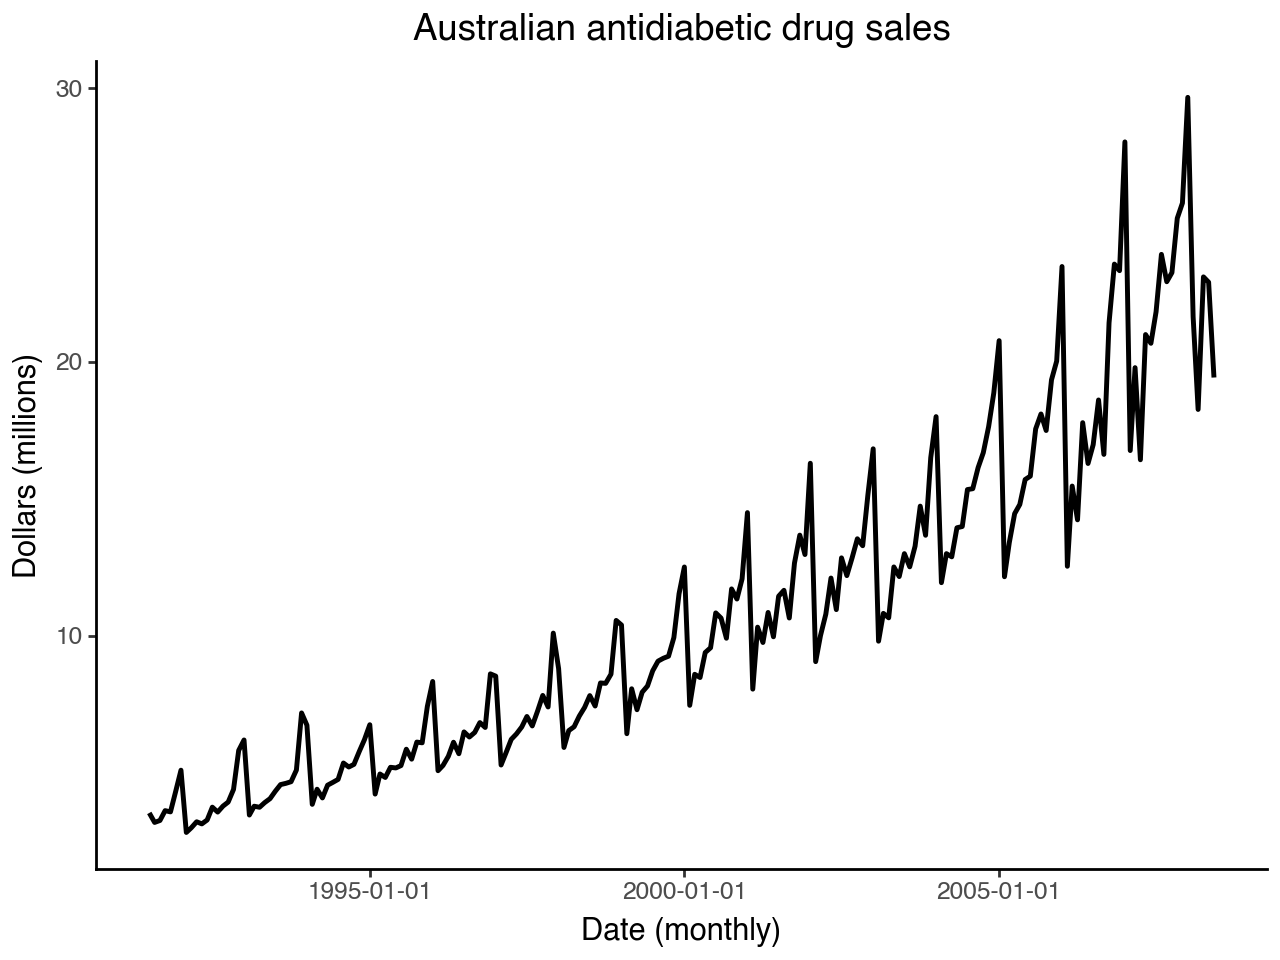

In [22]:
# Sales of pharmaceutical products in Australia summed by month across 
df_pbs = pd.read_csv('data/raw/PBS_unparsed.csv')
df_pbs["Month"] = pd.to_datetime(df_pbs["Month"])

# filter to a10 Anatomical Therapeutic Chemical index
df_a10 = df_pbs.query('ATC2 == "A10"')

total_cost_df = df_a10.groupby("Month", as_index=False).agg({"Cost": "sum"})
total_cost_df.rename(columns={"Cost": "TotalC"}, inplace=True)
total_cost_df['TotalC'] = total_cost_df['TotalC']/1e6

(ggplot(data=total_cost_df, mapping=aes(x='Month', y='TotalC')) + 
  geom_line(size=1) + 
  labs(x='Date (monthly)', y="Dollars (millions)") + 
  ggtitle(title='Australian antidiabetic drug sales') + 
  theme_classic())


## 2.3. Time series patterns

Three types of time series patterns: 

1. **Trend**: long-term change in data (linear or nonlienar).
2. **Seasonal**: changes over a fixed period of time caused due factors such as time of year, day of week, hour of day, etc. 
3. **Cyclic**: changes over at least 2 years that are not of a fixed frequency. Changes can be caused by economic conditions. 

To further distinguish cyclic from seasonal patterns, cyclic patterns often display more variability in change. 

## 2.4. Seasonal plots

Seasonal plots show change over time across seasons. Using the antidiabetic drug sale data, monthly sales are shown across each year. Using gas prices, monthly prices are shown as a function of year. 

1. Antidiabetic drug sales show highest sales in January followed by sharp decline in February and consequent slow increase through the year. 
2. Gas pump prices in toronto increase in the summer months. Note that this trend becomes more apparent when data from after 2005 are plotted. 

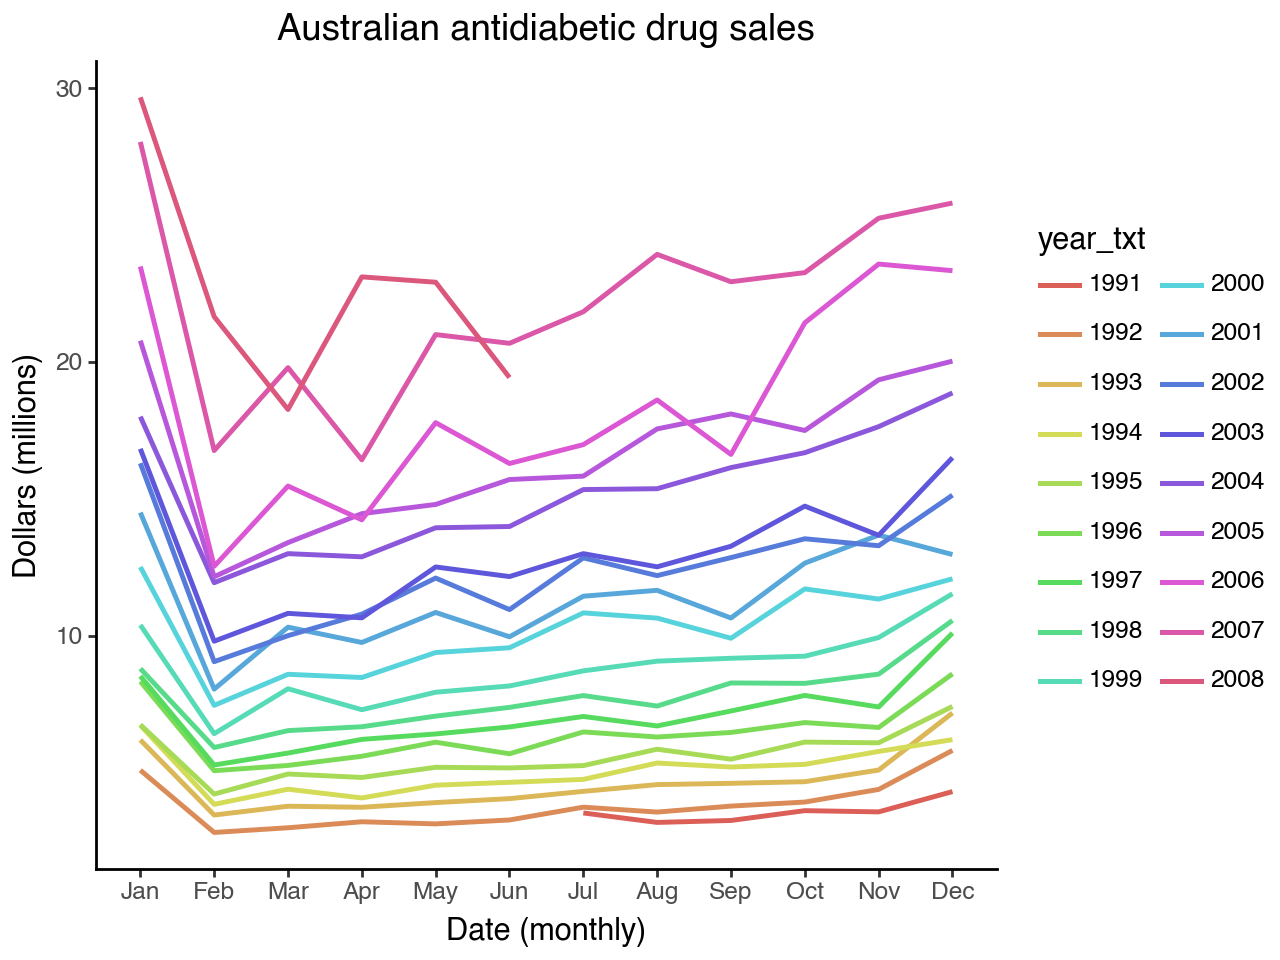

In [17]:
df_pbs = pd.read_csv('data/raw/PBS_unparsed.csv')
df_pbs["Month"] = pd.to_datetime(df_pbs["Month"])

# isolate for a10 ATC2 category 
df_a10 = df_pbs.query('ATC2 == "A10"')

df_total_cost = df_a10.groupby("Month", as_index=False).agg({"Cost": "sum"})
df_total_cost.rename(columns={"Cost": "TotalC"}, inplace=True)
df_total_cost['TotalC'] = df_total_cost['TotalC']/1e6

df_total_cost['month_txt'] = pd.to_datetime(df_pbs["Month"]).dt.strftime('%b')

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Convert to ordered categorical
df_total_cost['month_txt'] = pd.Categorical(df_total_cost['month_txt'], 
                                            categories=month_order, 
                                            ordered=True)

df_total_cost["year"] = pd.to_datetime(df_total_cost["Month"]).dt.year.astype(int)
df_total_cost['year_txt'] = df_total_cost['year'].astype(str)

# Monthly antidiabetic drug sales across years 
(ggplot(data=df_total_cost, mapping=aes(x='month_txt', y='TotalC', group='year_txt', color='year_txt')) + 
  geom_line(size=1) + 
  labs(x='Date (monthly)', y="Dollars (millions)") + 
  ggtitle(title='Australian antidiabetic drug sales') + 
  theme_classic())

In [15]:
df_toronto.loc[df_toronto['price'].ge(200)] 

,Date,Fuel Type,city,price,year_month,date_ymw,value,cpi_2025,price_2025,month_txt,year,year_txt
1689,2022-05-16,Regular Unleaded Gasoline,Toronto East/Est,207.9,2022-05,2022-05,288.4,0.685160,142.444660,May,2022,2022
1691,2022-05-30,Regular Unleaded Gasoline,Toronto East/Est,202.3,2022-05,2022-05,288.4,0.685160,138.607767,May,2022,2022
1692,2022-06-06,Regular Unleaded Gasoline,Toronto East/Est,213.8,2022-06,2022-06,300.0,0.658667,140.822933,Jun,2022,2022
1693,2022-06-13,Regular Unleaded Gasoline,Toronto East/Est,212.0,2022-06,2022-06,300.0,0.658667,139.637333,Jun,2022,2022
1694,2022-06-20,Regular Unleaded Gasoline,Toronto East/Est,200.3,2022-06,2022-06,300.0,0.658667,131.930933,Jun,2022,2022
1695,2022-06-27,Regular Unleaded Gasoline,Toronto East/Est,202.0,2022-06,2022-06,300.0,0.658667,133.050667,Jun,2022,2022


In [17]:
df_inflation = pd.read_csv('data/raw/1810000401_databaseLoadingData.csv')
df_inflation.columns = df_inflation.columns.str.lower()
df_gas_inf = df_inflation.query("`products and product groups` == 'Gasoline'").copy()
df_gas_inf

,ref_date,geo,dguid,products and product groups,uom,uom_id,scalar_factor,scalar_id,vector,coordinate,value,status,symbol,terminated,decimals
2550,1990-02,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,74.8,NaN,NaN,NaN,1
2551,1990-03,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,76.8,NaN,NaN,NaN,1
2552,1990-04,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,77.2,NaN,NaN,NaN,1
2553,1990-05,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,78.8,NaN,NaN,NaN,1
2554,1990-06,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,79.6,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,2025-02,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,226.1,NaN,NaN,NaN,1
2971,2025-03,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,223.2,NaN,NaN,NaN,1
2972,2025-04,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,193.0,NaN,NaN,NaN,1
2973,2025-05,Ontario,2016A000235,Gasoline,2002=100,17,units,0,v41691994,14.184,198.0,NaN,NaN,NaN,1


/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_3977/2244252035.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 5 rows containing missing values.


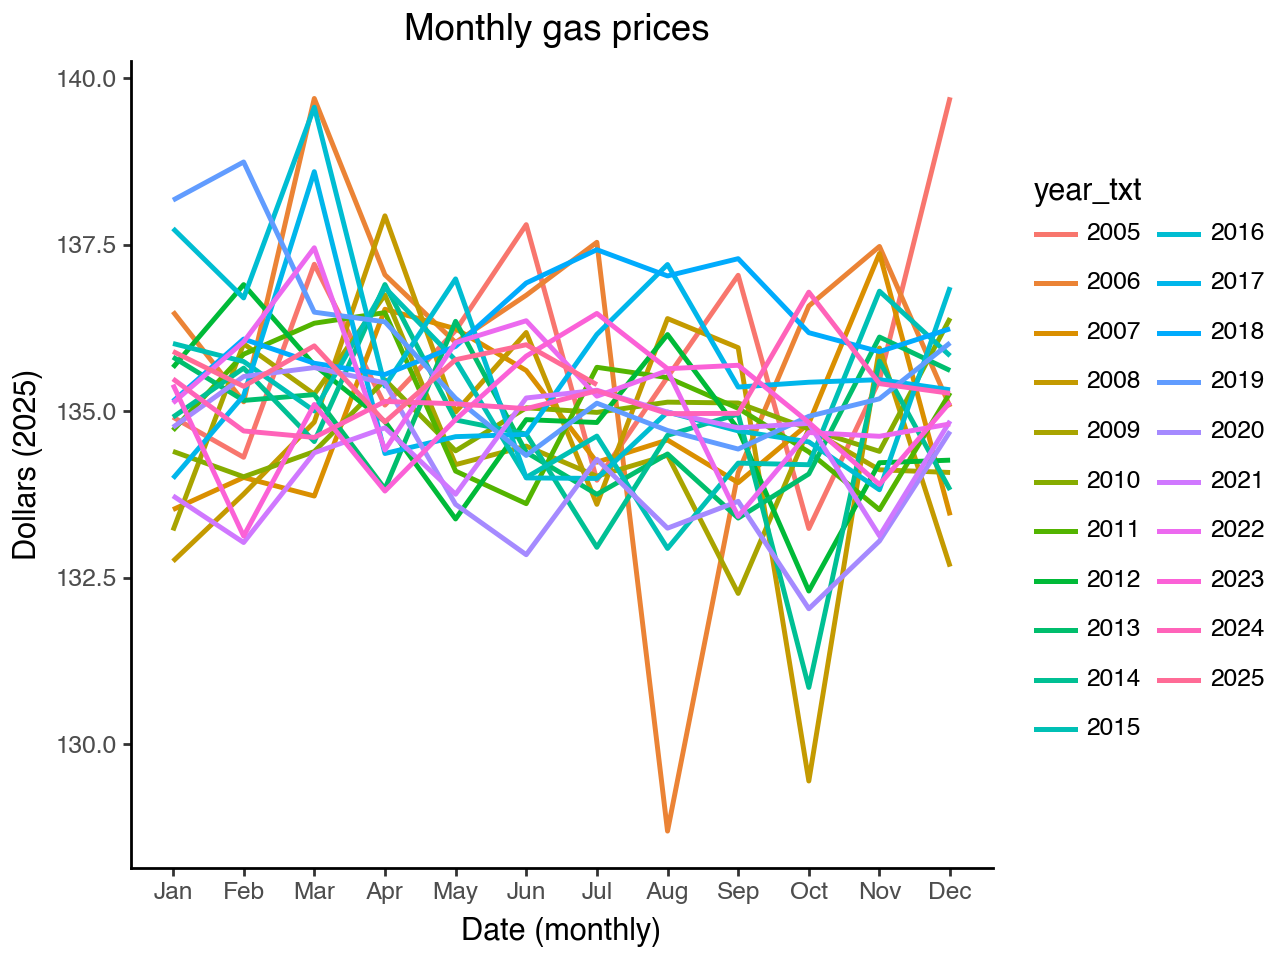

In [6]:
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

# compute average monthly gass prices
df_month = pd.DataFrame(df_toronto.groupby(['year', 'month_txt'])['price_2025'].mean()).reset_index()
df_month['year_txt'] = df_month['year'].astype(str)

(ggplot(data=df_month.loc[df_month['year'].ge(2005)], 
        mapping=aes(x='month_txt', y='price_2025', group='year_txt', color='year_txt')) + 
  geom_line(size=1) + 
  labs(x='Date (monthly)', y="Dollars (2025)") + 
  ggtitle(title='Monthly gas prices ') + 
  theme_classic())

## 2.5. Seasonal subseries plots

These plots might seasonal effects more effectively because they show data within each month across years



/var/folders/yc/2l2dbqc565l5ryrcfz4x3w680000gn/T/ipykernel_52454/2416769702.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/miniconda3/lib/python3.13/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


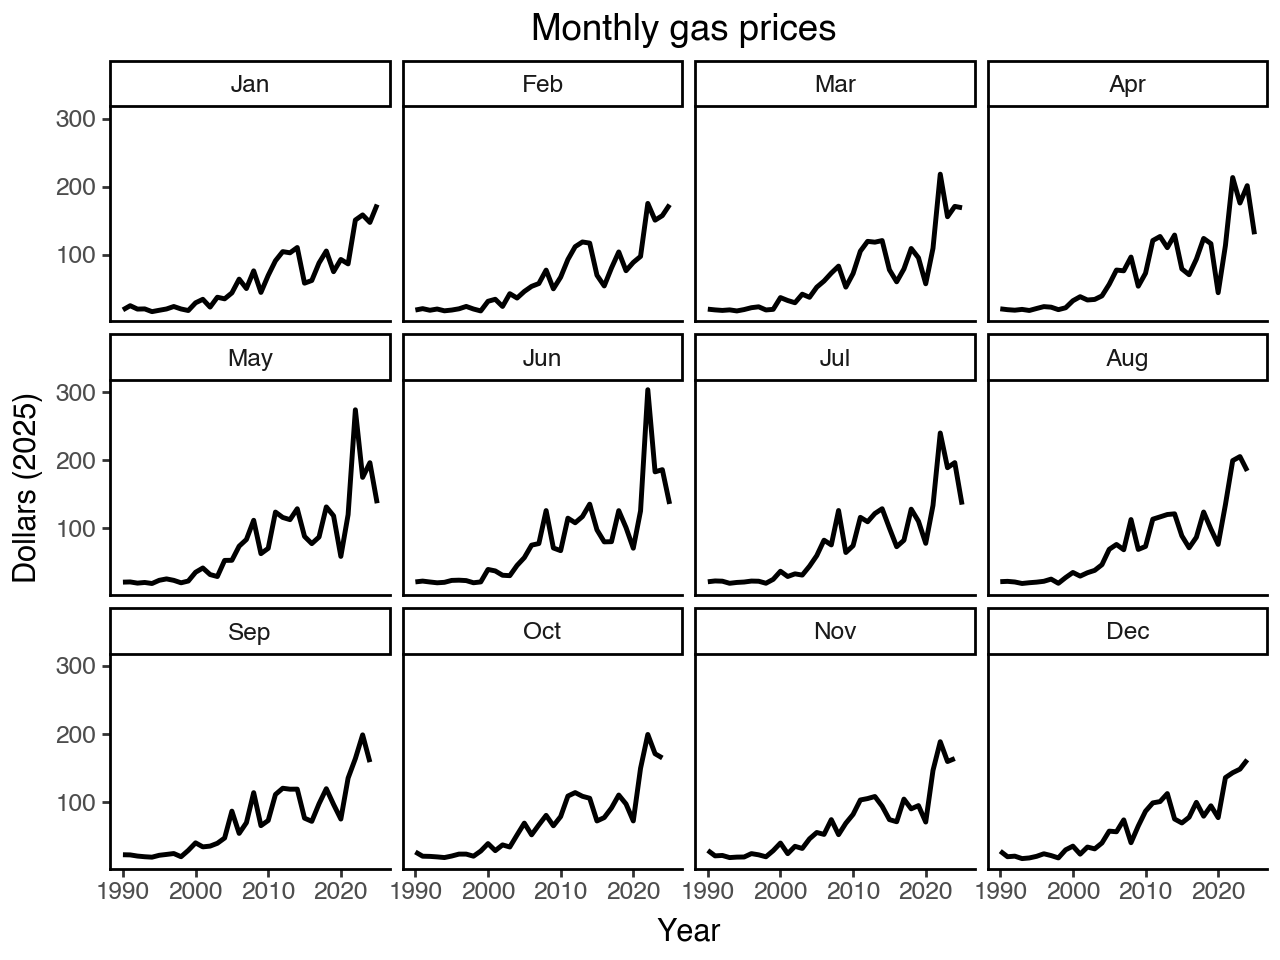

In [118]:
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

df_month = pd.DataFrame(df_toronto.groupby(['year', 'month_txt'])['price_2025'].mean()).reset_index()

(ggplot(data=df_month, 
        mapping=aes(x='year', y='price_2025')) + 
        facet_wrap(facets='~month_txt') + 
  geom_line(size=1) + 
  labs(x='Year', y="Dollars (2025)") + 
  ggtitle(title='Monthly gas prices ') + 
  theme_classic())

## 2.6. Scatterplots

Useful for examining patterns between variables. 

## 2.7. Lag plots

Lag plots can help uncover seasonal effects and more interesting temporal patterns. 

1. Australian beer production: beer production is summed within each quarter of each year and then plots with lagged versions ranging form 1 to 9 quarters in the past. 
2. Toronto gas prices: 

### Australian beer production

/opt/miniconda3/lib/python3.13/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 45 rows containing missing values.


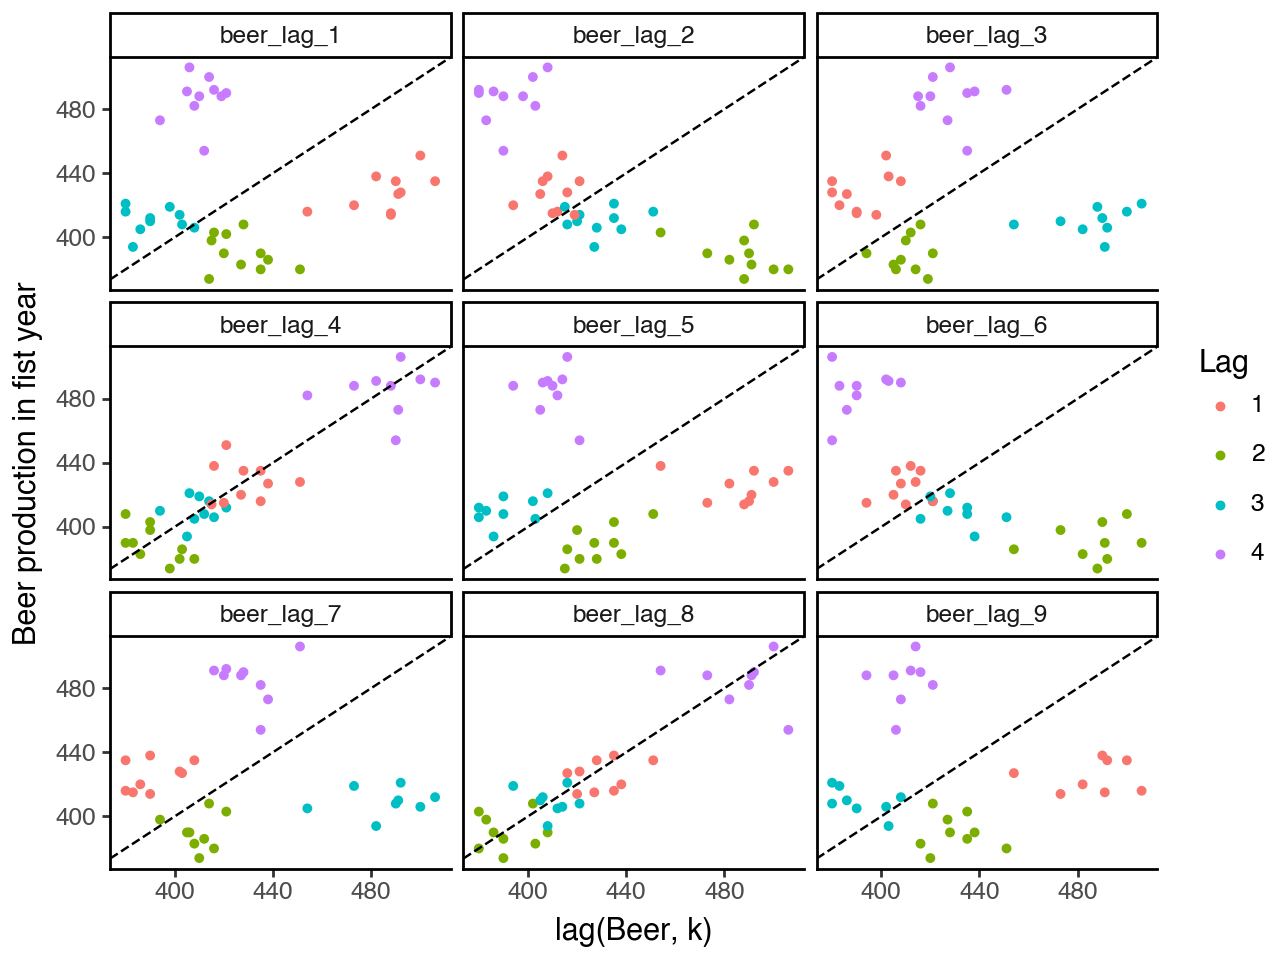

In [126]:
df_beer = pd.read_csv('data/raw/aus_production.csv')
df_beer['ds'] = pd.to_datetime(df_beer['ds'], format='%Y-%m-%d')

df_recent = df_beer[["ds", "Beer"]].query("ds >= 2000")
df_recent["Quarter"] = df_recent["ds"].dt.quarter

# create column of lagged values 
for lag in range(1, 10):
    df_recent[f"beer_lag_{lag}"] = df_recent["Beer"].shift(lag)

# convert to long format
df_recent_long = pd.melt(frame=df_recent, 
                         id_vars=['ds', 'Beer', 'Quarter'], 
                         var_name='lag', 
                         value_name='beer_prod')
(ggplot(data=df_recent_long, 
        mapping=aes(x='beer_prod', y='Beer', 
                    group='factor(Quarter)', color='factor(Quarter)')) + 
        facet_wrap(facets='~lag') + 
  geom_point(size=1) + 
  geom_abline(intercept=0, slope=1, linetype='dashed', color='black') +

  labs(x='lag(Beer, k)', y="Beer production in fist year", color='Lag') + 
  theme_classic())

### Toronto gas prices lag plot over quarterly period 

/opt/miniconda3/lib/python3.13/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_point : Removed 45 rows containing missing values.


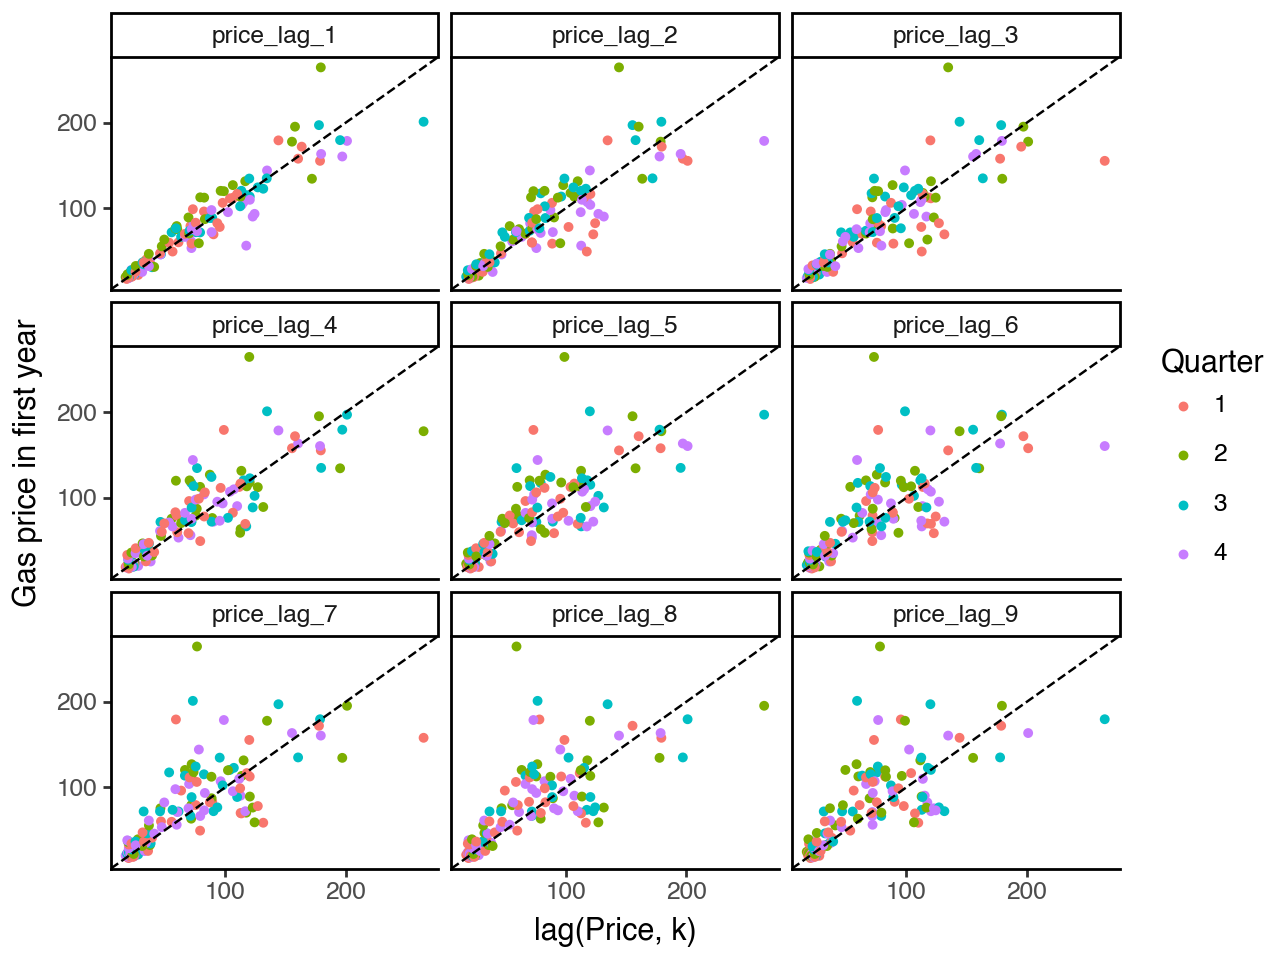

In [152]:
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

df_toronto["Quarter"] = df_toronto["Date"].dt.quarter

# compute quarterly data along with time lags 
df_quarter = pd.DataFrame(df_toronto.groupby(['year', 'Quarter'])['price_2025'].mean()).reset_index() 

# create column of lagged values 
for lag in range(1, 10):
    df_quarter[f"price_lag_{lag}"] = df_quarter["price_2025"].shift(lag)

# convert to long format
df_quarter_long = pd.melt(frame=df_quarter, 
                         id_vars=['year', 'Quarter', 'price_2025'], 
                         var_name='lag', 
                         value_name='lag_price_value')

(ggplot(data=df_quarter_long, 
        mapping=aes(x='lag_price_value', y='price_2025', 
                    group='factor(Quarter)', color='factor(Quarter)')) + 
        facet_wrap(facets='~lag') + 
  geom_point(size=1) + 
  geom_abline(intercept=0, slope=1, linetype='dashed', color='black') +

  labs(x='lag(Price, k)', y="Gas price in first year", color='Quarter') + 
  theme_classic())


##

## 2.8. Autocorrelation

Autocorrelation plots provide a more accurate method of examining lagged relationships. When data are seasonal, autocorrelations will be larger at certain lags (showing the correlations between seasons). 

1. Beer production: Negative correlations occur because troughs are two seasons apart. Strong positive correlations every four quarters. 
2. Toronto gas prices: Linearly decreasing autocorrelations suggest trend (which is confirmed by time series plot). 
3. White noise: provides a reference point for a time series with no trend or seasonal component. 

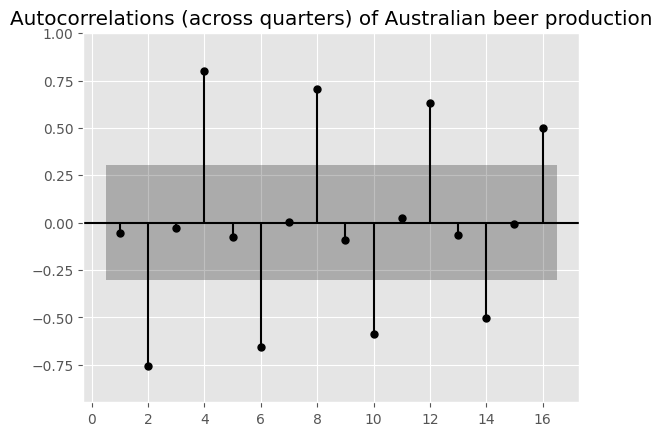

In [184]:
fig, ax = plt.subplots()
plot_acf(x=df_recent["Beer"], lags=16,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True,
         title="Autocorrelations (across quarters) of Australian beer production")

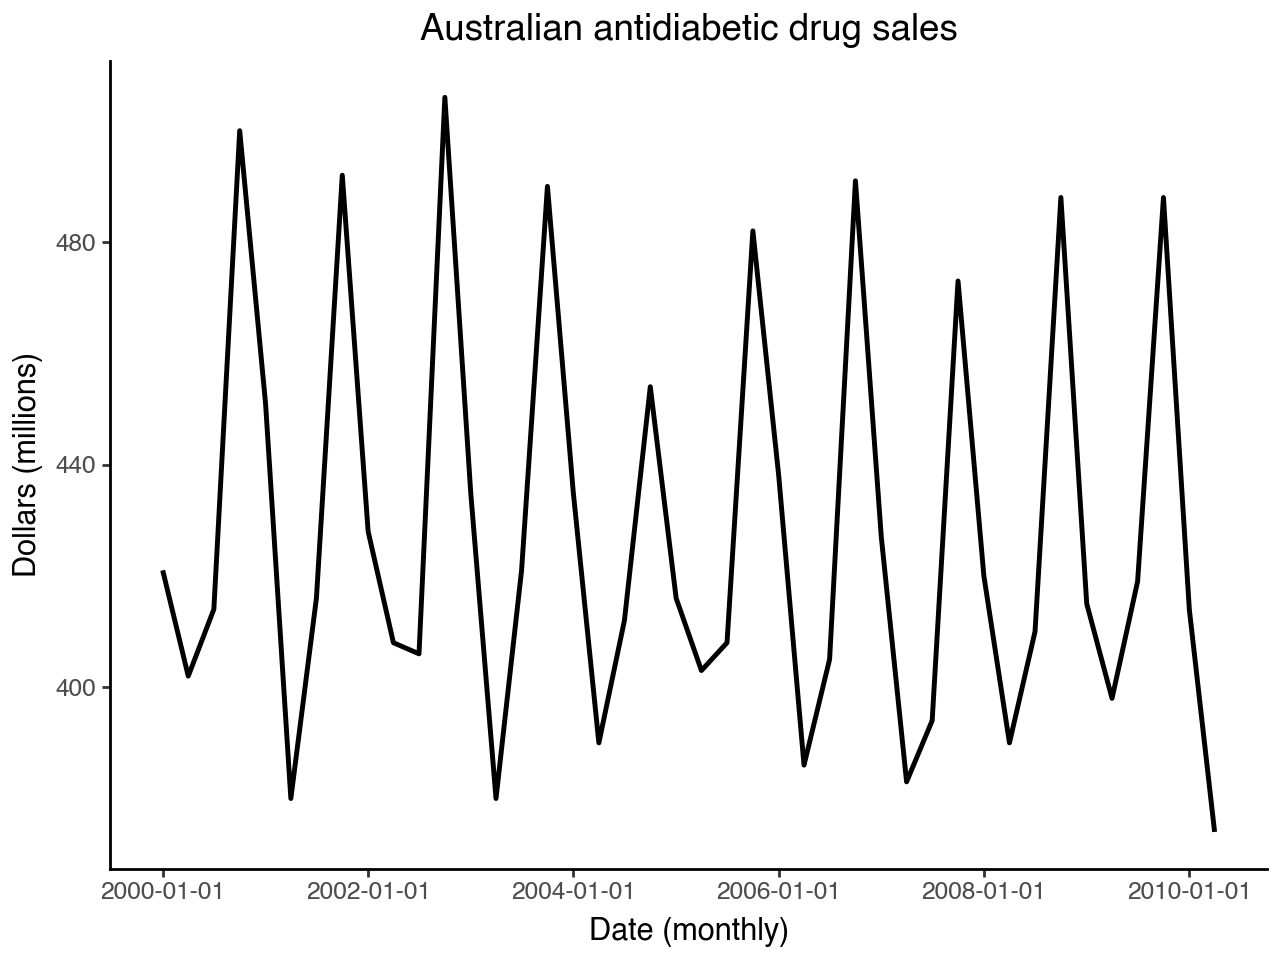

In [162]:
(ggplot(data=df_recent, mapping=aes(x='ds', y='Beer')) + 
  geom_line(size=1) + 
  labs(x='Date (monthly)', y="Dollars (millions)") + 
  ggtitle(title='Australian antidiabetic drug sales') + 
  theme_classic())

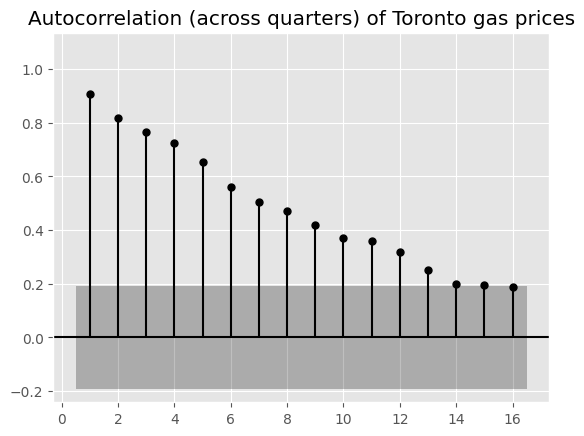

In [176]:
df_toronto = preprocess(path='data/processed/data_toronto_proc.csv', 
                        var_date='Date')

df_toronto["Quarter"] = df_toronto["Date"].dt.quarter

# compute quarterly data along with time lags 
df_quarter = pd.DataFrame(df_toronto.groupby(['year', 'Quarter'])['price_2025'].mean()).reset_index() 

# create column of lagged values 
for lag in range(1, 10):
    df_quarter[f"price_lag_{lag}"] = df_quarter["price_2025"].shift(lag)

# convert to long format
df_quarter_long = pd.melt(frame=df_quarter, 
                         id_vars=['year', 'Quarter', 'price_2025'], 
                         var_name='lag', 
                         value_name='lag_price_value')

fig, ax = plt.subplots()

plot_acf(x=df_quarter.loc[df_quarter['year'].ge(2000)].sort_values(['year', 'Quarter'], ascending=True)["price_2025"], lags=16,
         ax=ax,
         zero=False, bartlett_confint=False, auto_ylims=True, 
         title="Autocorrelation (across quarters) of Toronto gas prices")

In [171]:
df_quarter

,year,Quarter,price_2025,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_lag_8,price_lag_9
0,1990,1,19.458054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990,2,21.152922,19.458054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1990,3,22.067553,21.152922,19.458054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1990,4,27.812198,22.067553,21.152922,19.458054,NaN,NaN,NaN,NaN,NaN,NaN
4,1991,1,22.101629,27.812198,22.067553,21.152922,19.458054,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
138,2024,3,179.675819,195.416648,157.982960,160.551878,197.223069,177.880905,155.470015,178.775090,201.170558,264.735113
139,2024,4,163.532379,179.675819,195.416648,157.982960,160.551878,197.223069,177.880905,155.470015,178.775090,201.170558
140,2025,1,172.050211,163.532379,179.675819,195.416648,157.982960,160.551878,197.223069,177.880905,155.470015,178.775090
141,2025,2,134.543235,172.050211,163.532379,179.675819,195.416648,157.982960,160.551878,197.223069,177.880905,155.470015
